In [1]:
import base64
import numpy as np
import pandas as pd
import pickle
import time
from pprint import pprint
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
from collections import Counter
from scipy.misc import imread
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from matplotlib import pyplot as plt
import os
import numpy as np
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go
# tqdm
from tqdm import tqdm
init_notebook_mode(connected=True) #do not miss this line

from gensim import corpora, models, similarities

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline



import time
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['age-related', 'macular degeneration', 'amd', 'patients', 'macular','degeneration','however','may'])

In [3]:
# Import Dataset
df = pd.read_csv('papers.csv')
df.head()

,text,label,pubmed_id
0,We demonstrated the effectiveness of transpupi...,AMD,16922162
1,The electrogenesis of the retinal macular regi...,AMD,19284097
2,To define the role of increased fundus autoflu...,AMD,25982972
3,Retinal pigment epithelium (RPE)-derived membr...,AMD,20651235
4,Although a reduced aflibercept (2.0 mg) inject...,AMD,26296050


In [4]:
# Convert to list
data = df.text.values.tolist()
pmids = df.pubmed_id.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", str(sent)) for sent in data]

pprint(data[:1])

['We demonstrated the effectiveness of transpupillary thermotherapy (TTT) for '
 'the treatment of choroidal neovascularization (CNV) by patients with age- '
 'related macular degeneration (ARMD). CNV secondary to ARMD is a leading case '
 'of vision loss in patients older than 50 years. TTT is new promising method '
 'for the treatment CNV by ARMD. It is able to close CNV while maintaining '
 'visual function and in small percentage visual function improving. We have '
 'performed TTT by 30 patients (30 eyes) with subfoveolar CNV. We have '
 'demonstrated the stabilization or improvement of visual acuity by 16 '
 'patients (52%), improvemend two or more lines was documented by 5 patients '
 '(17%). ']


In [5]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['we', 'demonstrated', 'the', 'effectiveness', 'of', 'transpupillary', 'thermotherapy', 'ttt', 'for', 'the', 'treatment', 'of', 'choroidal', 'cnv', 'by', 'patients', 'with', 'age', 'related', 'macular', 'degeneration', 'armd', 'cnv', 'secondary', 'to', 'armd', 'is', 'leading', 'case', 'of', 'vision', 'loss', 'in', 'patients', 'older', 'than', 'years', 'ttt', 'is', 'new', 'promising', 'method', 'for', 'the', 'treatment', 'cnv', 'by', 'armd', 'it', 'is', 'able', 'to', 'close', 'cnv', 'while', 'maintaining', 'visual', 'function', 'and', 'in', 'small', 'percentage', 'visual', 'function', 'improving', 'we', 'have', 'performed', 'ttt', 'by', 'patients', 'eyes', 'with', 'subfoveolar', 'cnv', 'we', 'have', 'demonstrated', 'the', 'stabilization', 'or', 'improvement', 'of', 'visual', 'acuity', 'by', 'patients', 'improvemend', 'two', 'or', 'more', 'lines', 'was', 'documented', 'by', 'patients']]


In [6]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['we', 'demonstrated', 'the', 'effectiveness', 'of', 'transpupillary_thermotherapy_ttt', 'for', 'the', 'treatment', 'of', 'choroidal', 'cnv', 'by', 'patients', 'with', 'age', 'related', 'macular', 'degeneration', 'armd', 'cnv', 'secondary', 'to', 'armd', 'is', 'leading', 'case', 'of', 'vision', 'loss', 'in', 'patients', 'older', 'than', 'years', 'ttt', 'is', 'new', 'promising', 'method', 'for', 'the', 'treatment', 'cnv', 'by', 'armd', 'it', 'is', 'able', 'to', 'close', 'cnv', 'while', 'maintaining', 'visual', 'function', 'and', 'in', 'small', 'percentage', 'visual', 'function', 'improving', 'we', 'have', 'performed', 'ttt', 'by', 'patients', 'eyes', 'with', 'subfoveolar', 'cnv', 'we', 'have', 'demonstrated', 'the', 'stabilization', 'or', 'improvement', 'of', 'visual', 'acuity', 'by', 'patients', 'improvemend', 'two', 'or', 'more', 'lines', 'was', 'documented', 'by', 'patients']


In [7]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [8]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['demonstrate', 'effectiveness', 'transpupillary_thermotherapy', 'ttt', 'treatment', 'choroidal', 'cnv', 'age', 'relate', 'armd', 'cnv', 'secondary', 'armd', 'lead', 'case', 'vision', 'loss', 'old', 'year', 'ttt', 'new', 'promising', 'method', 'treatment', 'cnv', 'armd', 'able', 'close', 'cnv', 'maintain', 'visual', 'function', 'small', 'percentage', 'visual', 'function', 'improve', 'perform', 'ttt', 'eye', 'subfoveolar', 'cnv', 'demonstrate', 'stabilization', 'improvement', 'visual', 'acuity', 'improvemend', 'line', 'document']]


In [9]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
print(dict(id2word))

{0: 'able', 1: 'acuity', 2: 'age', 3: 'armd', 4: 'case', 5: 'choroidal', 6: 'close', 7: 'cnv', 8: 'demonstrate', 9: 'document', 10: 'effectiveness', 11: 'eye', 12: 'function', 13: 'improve', 14: 'improvemend', 15: 'improvement', 16: 'lead', 17: 'line', 18: 'loss', 19: 'maintain', 20: 'method', 21: 'new', 22: 'old', 23: 'percentage', 24: 'perform', 25: 'promising', 26: 'relate', 27: 'secondary', 28: 'small', 29: 'stabilization', 30: 'subfoveolar', 31: 'transpupillary_thermotherapy', 32: 'treatment', 33: 'ttt', 34: 'vision', 35: 'visual', 36: 'year', 37: 'activity', 38: 'aged', 39: 'amplitude', 40: 'atrophy', 41: 'average', 42: 'central', 43: 'change', 44: 'coherent', 45: 'component', 46: 'confluent', 47: 'correlation', 48: 'cystic', 49: 'datum', 50: 'decrease', 51: 'detachment', 52: 'different', 53: 'druzen', 54: 'electrogenesis', 55: 'erg', 56: 'establish', 57: 'extent', 58: 'exudative', 59: 'focal', 60: 'form', 61: 'foveal', 62: 'hexagon', 63: 'latency', 64: 'mf_erg', 65: 'mferg', 66:

In [10]:
# Create Corpus
texts = data_lemmatized

In [11]:
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 3), (4, 1), (5, 1), (6, 1), (7, 5), (8, 2), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 3), (34, 1), (35, 3), (36, 1)]]


In [12]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('able', 1),
  ('acuity', 1),
  ('age', 1),
  ('armd', 3),
  ('case', 1),
  ('choroidal', 1),
  ('close', 1),
  ('cnv', 5),
  ('demonstrate', 2),
  ('document', 1),
  ('effectiveness', 1),
  ('eye', 1),
  ('function', 2),
  ('improve', 1),
  ('improvemend', 1),
  ('improvement', 1),
  ('lead', 1),
  ('line', 1),
  ('loss', 1),
  ('maintain', 1),
  ('method', 1),
  ('new', 1),
  ('old', 1),
  ('percentage', 1),
  ('perform', 1),
  ('promising', 1),
  ('relate', 1),
  ('secondary', 1),
  ('small', 1),
  ('stabilization', 1),
  ('subfoveolar', 1),
  ('transpupillary_thermotherapy', 1),
  ('treatment', 2),
  ('ttt', 3),
  ('vision', 1),
  ('visual', 3),
  ('year', 1)]]

In [14]:
mallet_path = 'data/mallet-2.0.8/bin/mallet' # update this path

In [28]:
%%time
print("Training LDA model on dataframe...")

NUM_TOPICS = 70
start_time = time.time()
lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus,
                                             num_topics=NUM_TOPICS,
                                             iterations=1000, 
                                             optimize_interval=1,
                                             workers =4,
                                             id2word=id2word)
lda_model.save('models/model' + str(NUM_TOPICS) + '.gensim')
train_time = time.time() - start_time
print("Training Time --- %s seconds " % (round(train_time, 2)))

Training LDA model on dataframe...
Training Time --- 73.56 seconds 
CPU times: user 3.94 s, sys: 76.3 ms, total: 4.02 s
Wall time: 1min 13s


In [30]:
# Show Topics
pprint(lda_model.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(14,
  [('csc', 0.02650602409638554),
   ('exsudative', 0.023493975903614458),
   ('sleep', 0.01927710843373494),
   ('minute', 0.018072289156626505),
   ('peptide', 0.016867469879518072),
   ('light', 0.013855421686746987),
   ('dark_adaptation', 0.01325301204819277),
   ('drug', 0.010843373493975903),
   ('ccsc', 0.010240963855421687),
   ('rit', 0.00963855421686747)]),
 (40,
  [('mpod', 0.06425499620541361),
   ('pigment', 0.04047558816089046),
   ('subject', 0.02909182899064002),
   ('lutein', 0.027826966860612194),
   ('optical', 0.02580318745256767),
   ('density', 0.02529724260055654),
   ('increase', 0.02251454591449532),
   ('carotenoid', 0.02251454591449532),
   ('supplementation', 0.020996711358461928),
   ('measure', 0.019984821654439665)]),
 (34,
  [('ivb', 0.08781869688385269),
   ('ivt', 0.05004721435316336),
   ('case', 0.031161473087818695),
   ('report', 0.025495750708215296),
   ('patient', 0.023607176581680833),
   ('present', 0.018413597733711047),
   ('leave', 0.

In [31]:
lda_model_updated = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(lda_model)

In [32]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_updated, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
52     0.000058 -0.000077       1        1  10.555301
11    -0.000100 -0.000020       2        1   7.620218
60    -0.000104 -0.000453       3        1   6.955419
1     -0.000127 -0.000152       4        1   4.474800
66    -0.000039  0.000039       5        1   4.226472
46    -0.000024  0.000043       6        1   4.073867
12     0.000231 -0.000172       7        1   3.844767
54     0.000220  0.000091       8        1   3.186697
26    -0.000030  0.000051       9        1   2.916952
42    -0.000159  0.000337      10        1   2.584790
33    -0.000067  0.000052      11        1   2.492396
63     0.000348 -0.000289      12        1   2.246755
2      0.000439  0.000103      13        1   2.143432
45     0.000037 -0.000361      14        1   2.049970
31     0.000114  0.000391      15        1   1.934690
62    -0.000577  0.000460      16        1   1.907357
61     0.000126  0.000296      17        1   1.383559
37    -0.000286  0.000025      18        1   1.360762
59     0.000044  0.000224      19        1   1.307981
53     0.000090  0.000218      20        1   1.283799
57    -0.000036  0.000202      21        1   1.262000
67    -0.000055  0.000049      22        1   1.207381
16     0.000150 -0.000294      23        1   1.159909
28    -0.000143 -0.000363      24        1   1.140729
23     0.000135  0.000538      25        1   1.092826
39    -0.000445 -0.000258      26        1   1.027409
17    -0.000082  0.000135      27        1   1.025826
15     0.000062  0.000282      28        1   1.000644
27    -0.000300 -0.000082      29        1   0.983830
56    -0.000188 -0.000297      30        1   0.978167
...         ...       ...     ...      ...        ...
50     0.000281  0.000124      41        1   0.730640
3     -0.000074  0.000059      42        1   0.611244
25    -0.000129  0.000114      43        1   0.591702
29     0.000138 -0.000029      44        1   0.589423
24    -0.000250  0.000106      45        1   0.555204
49     0.000042 -0.000076      46        1   0.536588
43    -0.000068  0.000147      47        1   0.519242
51    -0.000248 -0.000193      48        1   0.490573
5     -0.000147 -0.000377      49        1   0.485216
44    -0.000376 -0.000196      50        1   0.476076
64     0.000183 -0.000016      51        1   0.466221
32    -0.000295  0.000218      52        1   0.456701
58     0.000355 -0.000015      53        1   0.455545
68     0.000202  0.000096      54        1   0.446923
47    -0.000224  0.000090      55        1   0.420652
8      0.000043 -0.000085      56        1   0.414527
38     0.000140 -0.000044      57        1   0.398239
55     0.000062  0.000125      58        1   0.393841
65    -0.000307 -0.000170      59        1   0.384865
10     0.000325  0.000298      60        1   0.384260
40     0.000298 -0.000042      61        1   0.340274
7     -0.000306 -0.000137      62        1   0.324296
4     -0.000059 -0.000067      63        1   0.320092
20     0.000214  0.000026      64        1   0.264738
0     -0.000184 -0.000337      65        1   0.238842
6      0.000311 -0.000193      66        1   0.228512
34    -0.000157 -0.000085      67        1   0.182210
35    -0.000343  0.000071      68        1   0.174811
14    -0.000008  0.000400      69        1   0.154513
9     -0.000043  0.000374      70        1   0.139747

[70 rows x 5 columns], topic_info=      Category       Freq            Term      Total  loglift  logprob
term                                                                  
10028  Default  44.000000          stance  44.000000  30.0000  30.0000
11908  Default  45.000000        latently  45.000000  29.0000  29.0000
4976   Default  43.000000        favoured  43.000000  28.0000  28.0000
3142   Default  44.000000          easily  44.000000  27.0000  27.0000
6938   Default  44.000000      monophasic  44.000000  26.0000  26.0000
9208   Default  44.000000          

In [58]:
%%time
print("Training LDA model on dataframe...")

NUM_TOPICS = 80
start_time = time.time()
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=NUM_TOPICS, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=1000,
                                           passes=40,
                                           alpha='auto',
                                           per_word_topics=True)
lda_model.save('models/model' + str(NUM_TOPICS) + '.gensim')
train_time = time.time() - start_time
print("Training Time --- %s seconds " % (round(train_time, 2)))

Training LDA model on dataframe...
Training Time --- 1144.53 seconds 
CPU times: user 56min 8s, sys: 2min 7s, total: 58min 15s
Wall time: 19min 4s


In [59]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(73,
  '0.103*"newly_diagnos" + 0.082*"september" + 0.072*"newly_diagnosed" + '
  '0.064*"attenuate" + 0.055*"beneficiary" + 0.046*"university_hospital" + '
  '0.045*"circulation" + 0.036*"srd" + 0.030*"nucleus" + 0.024*"pubmed"'),
 (31,
  '0.084*"intravitreous" + 0.066*"aqueous" + 0.049*"senescence" + '
  '0.046*"antagonist" + 0.032*"stabilisation" + 0.030*"bmp" + 0.025*"constant" '
  '+ 0.021*"definite" + 0.021*"cri" + 0.021*"rbp"'),
 (33,
  '0.159*"crp" + 0.058*"wamd" + 0.051*"reactive_protein" + 0.050*"iai" + '
  '0.033*"recognition" + 0.025*"context" + 0.023*"visually" + 0.020*"island" + '
  '0.018*"mg" + 0.017*"rely"'),
 (30,
  '0.073*"peptide" + 0.051*"conversion" + 0.050*"monkey" + 0.037*"compose" + '
  '0.036*"amyloid" + 0.035*"absolute" + 0.034*"private" + 0.033*"fourth" + '
  '0.028*"indicator" + 0.024*"aggregation"'),
 (12,
  '0.165*"sub" + 0.059*"dha" + 0.058*"unit" + 0.047*"adherence" + '
  '0.043*"peripapillary" + 0.034*"ct" + 0.025*"long_chain" + 0.025*"matrix" + '
  '

In [60]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.617456188282157

Coherence Score:  0.49745744681482107


In [14]:
mallet_path = 'data/mallet-2.0.8/bin/mallet' # update this path

In [57]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(58,
  [('test', 0.08475378787878787),
   ('device', 0.03125),
   ('exsudative', 0.023200757575757576),
   ('classical', 0.018465909090909092),
   ('average', 0.016571969696969696),
   ('monitor', 0.014678030303030304),
   ('detection', 0.014204545454545454),
   ('php', 0.014204545454545454),
   ('home', 0.011363636363636364),
   ('preferential_hyperacuity', 0.010890151515151516)]),
 (20,
  [('mpod', 0.059995257291913684),
   ('pigment', 0.03983874792506521),
   ('lutein', 0.035807446051695516),
   ('supplementation', 0.02987906094379891),
   ('increase', 0.028456248517903723),
   ('carotenoid', 0.024899217453165756),
   ('optical', 0.022527863410007114),
   ('density', 0.022527863410007114),
   ('mg', 0.01897083234526915),
   ('measure', 0.017073749110742234)]),
 (31,
  [('trial', 0.061802455357142856),
   ('evidence', 0.0224609375),
   ('people', 0.0205078125),
   ('participant', 0.020089285714285716),
   ('effect', 0.016880580357142856),
   ('include', 0.016741071428571428),
   ('r

In [23]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus,
                                             num_topics=num_topics,
                                             iterations=1000, 
                                             optimize_interval=1,
                                             workers =4,
                                             id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [25]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=data_lemmatized, 
                                                        start=40, limit=100, 
                                                        step=5)

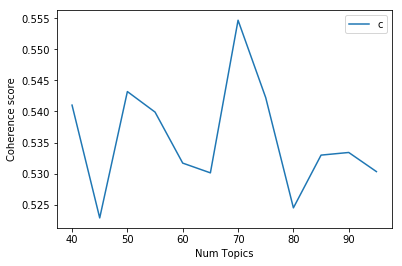

In [26]:
# Show graph
limit=100; start=40; step=5;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [33]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 40  has Coherence Value of 0.541
Num Topics = 45  has Coherence Value of 0.5229
Num Topics = 50  has Coherence Value of 0.5432
Num Topics = 55  has Coherence Value of 0.5399
Num Topics = 60  has Coherence Value of 0.5317
Num Topics = 65  has Coherence Value of 0.5301
Num Topics = 70  has Coherence Value of 0.5547
Num Topics = 75  has Coherence Value of 0.5422
Num Topics = 80  has Coherence Value of 0.5245
Num Topics = 85  has Coherence Value of 0.533
Num Topics = 90  has Coherence Value of 0.5334
Num Topics = 95  has Coherence Value of 0.5303


In [34]:
optimal_model = model_list[4]
# optimal_model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=20))

[(26,
  '0.056*"apoe" + 0.038*"cep" + 0.036*"age" + 0.028*"fold" + 0.023*"increase" '
  '+ 0.019*"epsilon" + 0.015*"decrease" + 0.014*"approximately" + '
  '0.013*"relate" + 0.013*"donor" + 0.012*"gstm" + 0.012*"relative" + '
  '0.010*"disease" + 0.010*"protein" + 0.009*"sfasl" + 0.009*"adduct" + '
  '0.009*"cml" + 0.009*"young" + 0.008*"transport" + 0.008*"isoform"'),
 (0,
  '0.086*"eye" + 0.056*"vma" + 0.040*"vitreous" + 0.034*"pvd" + '
  '0.031*"vitreomacular_adhesion" + 0.030*"posterior_vitreous" + '
  '0.026*"detachment" + 0.023*"exudative" + 0.020*"hole" + 0.018*"vmt" + '
  '0.017*"vitreomacular_traction" + 0.014*"optical_coherence" + '
  '0.013*"tomography" + 0.013*"vitreoretinal" + 0.013*"retinal" + '
  '0.012*"release" + 0.011*"relate" + 0.011*"adhesion" + 0.010*"vitrectomy" + '
  '0.010*"vitreomacular_interface"'),
 (30,
  '0.060*"mpod" + 0.038*"pigment" + 0.035*"lutein" + 0.028*"subject" + '
  '0.027*"supplementation" + 0.026*"increase" + 0.024*"density" + '
  '0.023*"carote

In [35]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    pids = pd.Series(pmids)
    sent_topics_df = pd.concat([sent_topics_df, contents,pids], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text','PMIDS']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,PMIDS
0,0,14.0,0.4817,"cnv, eye, choroidal, laser, occult, angiograph...",We demonstrated the effectiveness of transpupi...,16922162
1,1,13.0,0.6363,"response, amplitude, retinal, function, mferg,...",The electrogenesis of the retinal macular regi...,19284097
2,2,29.0,0.4893,"eye, year, study, baseline, fellow, progressio...",To define the role of increased fundus autoflu...,25982972
3,3,6.0,0.6215,"protein, retinal, cell, age, retina, oxidative...",Retinal pigment epithelium (RPE)-derived membr...,20651235
4,4,34.0,0.2307,"treatment, ranibizumab, letter, injection, mon...",Although a reduced aflibercept (2.0 mg) inject...,26296050
5,5,18.0,0.4579,"hemorrhage, surgery, subretinal, translocation...",The place of surgery in DMLA amounts to the su...,14586233
6,6,32.0,0.3604,"complement, activation, factor, cfh, protein, ...",Age related macular degeneration (AMD) is the ...,28424619
7,7,17.0,0.4469,"risk, year, incidence, baseline, cohort, late,...",To assess the association between smoking and ...,17698756
8,8,51.0,0.8138,"rs, risk, cfh, association, polymorphism, gene...",To evaluate the association of CC-cytokine lig...,27316788
9,9,2.0,0.7617,"trial, study, mg, group, safety, treatment, we...",Safety data for anecortave acetate 15 mg suspe...,17240259


In [36]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text","PMIDS"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text,PMIDS
0,0.0,0.5836,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To compare the state of the posterior vitreous...,17884003
1,1.0,0.9332,"response, responder, treatment, rmd, nonrespon...",Bei der altersabhängigen Makuladegeneration (A...,17957685
2,2.0,0.8001,"trial, study, mg, group, safety, treatment, we...",Long-term efficacy and safety profile of pegap...,21400918
3,3.0,0.6887,"visual, acuity, eye, month, follow, year, line...",To evaluate the changes in the best-corrected ...,22173070
4,4.0,0.3847,"exudative, age, study, nonexudative, relate, s...",To examine the importance of genetic factors i...,10463414


In [37]:
sent_topics_sorteddf_mallet['Keywords'][0]

'eye, vma, vitreous, pvd, vitreomacular_adhesion, posterior_vitreous, detachment, exudative, hole, vmt'

In [38]:
tempDf = df_dominant_topic
tempDf = tempDf.sort_values(by=['Dominant_Topic']).reset_index()
del tempDf['index']
tempDf

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,PMIDS
0,2790,0.0,0.2565,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To assess the prevalence of vitreomacular adhe...,28214102
1,1439,0.0,0.3243,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",The aim of this study was to assess the preval...,28297034
2,2941,0.0,0.5836,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To compare the state of the posterior vitreous...,17884003
3,986,0.0,0.3009,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To investigate the influence of the vitreomacu...,23870300
4,1686,0.0,0.2555,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To assess the association of the vitreomacular...,25824327
5,4954,0.0,0.3571,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",Ischemia and hypoxia have been implicated in t...,20951826
6,2419,0.0,0.3052,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To assess the incidence of vitreomacular adhes...,18538742
7,6564,0.0,0.3767,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To investigate the association of posterior vi...,25863675
8,7207,0.0,0.3761,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To determine if there is an association of vit...,23591535
9,3004,0.0,0.2911,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",To report a case of bilateral nonsequential ma...,25390731


In [39]:
# Number of Documents for Each Topic
topic_counts = tempDf['Dominant_Topic'].value_counts()
topic_counts

20.0    1165
5.0      491
51.0     489
40.0     300
34.0     279
3.0      218
7.0      199
50.0     182
16.0     169
9.0      158
22.0     157
6.0      154
2.0      148
47.0     142
19.0     132
49.0     130
12.0     124
18.0     123
14.0     123
33.0     117
23.0     113
54.0     113
28.0     108
38.0     102
41.0     100
25.0      98
17.0      93
44.0      93
21.0      91
48.0      90
32.0      90
36.0      88
45.0      86
10.0      81
29.0      80
43.0      78
31.0      78
24.0      71
56.0      68
13.0      68
30.0      59
57.0      59
55.0      57
37.0      55
35.0      55
11.0      55
39.0      53
46.0      52
59.0      50
52.0      48
58.0      42
8.0       34
42.0      34
0.0       28
27.0      23
26.0      21
15.0      18
1.0       12
53.0       8
4.0        8
Name: Dominant_Topic, dtype: int64

In [40]:
topic_counts.sum()

7560

In [138]:
3/7560

0.0003968253968253968

In [41]:
topic_contribution = topic_counts/topic_counts.sum()

In [42]:
# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']].drop_duplicates()
topic_num_keywords = topic_num_keywords.reset_index()
del topic_num_keywords['index']
topic_num_keywords = topic_num_keywords.sort_values(by=['Dominant_Topic']).reset_index()
del topic_num_keywords['index']
topic_num_keywords

,Dominant_Topic,Topic_Keywords
0,0.0,"eye, vma, vitreous, pvd, vitreomacular_adhesio..."
1,1.0,"response, responder, treatment, rmd, nonrespon..."
2,2.0,"trial, study, mg, group, safety, treatment, we..."
3,3.0,"visual, acuity, eye, month, follow, year, line..."
4,4.0,"exudative, age, study, nonexudative, relate, s..."
5,5.0,"month, injection, intravitreal, bcva, baseline..."
6,6.0,"protein, retinal, cell, age, retina, oxidative..."
7,7.0,"oct, image, retinal, optical_coherence, faf, t..."
8,8.0,"cataract, cataract_surgery, eye, surgery, lens..."
9,9.0,"risk, factor, age, association, associate, smo..."


In [43]:
# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Dominant_Topic,Dominant_Topic
0,0.0,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",28,0.003704
1,1.0,"response, responder, treatment, rmd, nonrespon...",12,0.001587
2,2.0,"trial, study, mg, group, safety, treatment, we...",148,0.019577
3,3.0,"visual, acuity, eye, month, follow, year, line...",218,0.028836
4,4.0,"exudative, age, study, nonexudative, relate, s...",8,0.001058
5,5.0,"month, injection, intravitreal, bcva, baseline...",491,0.064947
6,6.0,"protein, retinal, cell, age, retina, oxidative...",154,0.020370
7,7.0,"oct, image, retinal, optical_coherence, faf, t...",199,0.026323
8,8.0,"cataract, cataract_surgery, eye, surgery, lens...",34,0.004497
9,9.0,"risk, factor, age, association, associate, smo...",158,0.020899


In [44]:
# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,0.0,"eye, vma, vitreous, pvd, vitreomacular_adhesio...",28,0.003704
1,1.0,"response, responder, treatment, rmd, nonrespon...",12,0.001587
2,2.0,"trial, study, mg, group, safety, treatment, we...",148,0.019577
3,3.0,"visual, acuity, eye, month, follow, year, line...",218,0.028836
4,4.0,"exudative, age, study, nonexudative, relate, s...",8,0.001058
5,5.0,"month, injection, intravitreal, bcva, baseline...",491,0.064947
6,6.0,"protein, retinal, cell, age, retina, oxidative...",154,0.020370
7,7.0,"oct, image, retinal, optical_coherence, faf, t...",199,0.026323
8,8.0,"cataract, cataract_surgery, eye, surgery, lens...",34,0.004497
9,9.0,"risk, factor, age, association, associate, smo...",158,0.020899
